# E4 네이버 영화리뷰 감성분석 도전하기
일시: 2020년 1월 14일 목요일

# Step 1. 데이터 준비와 확인

**1. 네이버 영화의 댓글을 모아 구성된 [Naver sentiment movie corpus](https://github.com/e9t/nsmc)를 다운받아줍니다.**

```
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/sentiment_classification
```

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# Step 2. 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

**2. 위 작업으로 데이터 로더를 구성합니다.**

In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# Step 3. 모델구성을 위한 데이터 분석 및 가공

In [5]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


**3. 데이터셋 내 문장 길이 분포를 파악합니다.** 

In [6]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [7]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


**4. 적절한 최대 문장 길이를 지정합니다.**

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2*표준편차)로 설정  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


**5. ```keras.preprocessing.sequence.pad_sequences```을 활용한 패딩 추가합니다.**

In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


# Step 4. 모델 구성 및 validation set 구성

**6. RNN, 1-D Convolution Neural Network(1-D CNN), GlobalMaxPooling1D() 레이어 하나만 사용하는 방법을 가지고 3가지 모델을 구성합니다.**

## (1) RNN

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000    
word_vector_dim = 16  

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(keras.layers.LSTM(8))   
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


## (2) 1-D Convolution Neural Network(1-D CNN)

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = 10000 
word_vector_dim = 16 

model_oned = keras.Sequential()
model_oned.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_oned.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_oned.add(keras.layers.MaxPooling1D(5))
model_oned.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_oned.add(keras.layers.GlobalMaxPooling1D())
model_oned.add(keras.layers.Dense(8, activation='relu'))
model_oned.add(keras.layers.Dense(1, activation='sigmoid'))  

model_oned.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [12]:
vocab_size = 10000  
word_vector_dim = 16   

model_max = keras.Sequential()
model_max.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_max.add(keras.layers.GlobalMaxPooling1D())
model_max.add(keras.layers.Dense(8, activation='relu'))
model_max.add(keras.layers.Dense(1, activation='sigmoid'))  

model_max.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


**7. Training set과 validation set을 구성합니다.**

In [13]:
# validation set 20000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 30000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


# Step 5. 모델 훈련 개시 

**8. 구성한 3가지 모델을 각자 훈련시켜 줍니다.**

## (1) RNN

In [14]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 13

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/13
188/188 [==============================] - 3s 18ms/step - loss: 0.5325 - accuracy: 0.7575 - val_loss: 0.3846 - val_accuracy: 0.8330
Epoch 2/13
188/188 [==============================] - 3s 16ms/step - loss: 0.3466 - accuracy: 0.8541 - val_loss: 0.3512 - val_accuracy: 0.8479
Epoch 3/13
188/188 [==============================] - 3s 16ms/step - loss: 0.3177 - accuracy: 0.8686 - val_loss: 0.3524 - val_accuracy: 0.8470
Epoch 4/13
188/188 [==============================] - 3s 16ms/step - loss: 0.3024 - accuracy: 0.8763 - val_loss: 0.3491 - val_accuracy: 0.8495
Epoch 5/13
188/188 [==============================] - 3s 16ms/step - loss: 0.2884 - accuracy: 0.8826 - val_loss: 0.3538 - val_accuracy: 0.8485
Epoch 6/13
188/188 [==============================] - 3s 16ms/step - loss: 0.2768 - accuracy: 0.8881 - val_loss: 0.3626 - val_accuracy: 0.8461
Epoch 7/13
188/188 [==============================] - 3s 16ms/step - loss: 0.2662 - accuracy: 0.8934 - val_loss: 0.3630 - val_accuracy: 0.8473

## (2) 1-D Convolution Neural Network(1-D CNN)

In [15]:
model_oned.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 13

history_oned = model_oned.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/13
188/188 [==============================] - 1s 7ms/step - loss: 0.5066 - accuracy: 0.7469 - val_loss: 0.3620 - val_accuracy: 0.8419
Epoch 2/13
188/188 [==============================] - 1s 6ms/step - loss: 0.3329 - accuracy: 0.8579 - val_loss: 0.3456 - val_accuracy: 0.8506
Epoch 3/13
188/188 [==============================] - 1s 6ms/step - loss: 0.2956 - accuracy: 0.8767 - val_loss: 0.3475 - val_accuracy: 0.8499
Epoch 4/13
188/188 [==============================] - 1s 6ms/step - loss: 0.2648 - accuracy: 0.8933 - val_loss: 0.3562 - val_accuracy: 0.8489
Epoch 5/13
188/188 [==============================] - 1s 7ms/step - loss: 0.2302 - accuracy: 0.9105 - val_loss: 0.3675 - val_accuracy: 0.8480
Epoch 6/13
188/188 [==============================] - 1s 6ms/step - loss: 0.1923 - accuracy: 0.9283 - val_loss: 0.3966 - val_accuracy: 0.8449
Epoch 7/13
188/188 [==============================] - 1s 6ms/step - loss: 0.1569 - accuracy: 0.9449 - val_loss: 0.4408 - val_accuracy: 0.8388
Epoch 

## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [16]:
model_max.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 13

history_max = model_max.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/13
188/188 [==============================] - 1s 3ms/step - loss: 0.6047 - accuracy: 0.7461 - val_loss: 0.4638 - val_accuracy: 0.8142
Epoch 2/13
188/188 [==============================] - 1s 3ms/step - loss: 0.3971 - accuracy: 0.8337 - val_loss: 0.3720 - val_accuracy: 0.8356
Epoch 3/13
188/188 [==============================] - 1s 3ms/step - loss: 0.3352 - accuracy: 0.8580 - val_loss: 0.3567 - val_accuracy: 0.8419
Epoch 4/13
188/188 [==============================] - 1s 3ms/step - loss: 0.3039 - accuracy: 0.8738 - val_loss: 0.3541 - val_accuracy: 0.8439
Epoch 5/13
188/188 [==============================] - 1s 3ms/step - loss: 0.2807 - accuracy: 0.8854 - val_loss: 0.3574 - val_accuracy: 0.8449
Epoch 6/13
188/188 [==============================] - 1s 3ms/step - loss: 0.2621 - accuracy: 0.8936 - val_loss: 0.3645 - val_accuracy: 0.8439
Epoch 7/13
188/188 [==============================] - 1s 3ms/step - loss: 0.2457 - accuracy: 0.9013 - val_loss: 0.3730 - val_accuracy: 0.8427
Epoch 

# Step 6. Loss, Accuracy 그래프 시각화

**9. 각 모델의 성능평가를 하고, 각 결과에 대한 히스토리를 참고하여, Traing과 validation set에 대한 Loss와 Accuracy에 대한 그래프를 그립니다.    
그래프를 통해 몇 에포크까지의 트레이닝 적정한지 최적점을 추정해볼 수 있습니다.** 

## (1) RNN

In [17]:
results_rnn = model_rnn.evaluate(X_test,  y_test, verbose=2)

print(results_rnn)

1537/1537 - 3s - loss: 0.4182 - accuracy: 0.8364
[0.4182337522506714, 0.8364017605781555]


In [18]:
history_dict_rnn = history_rnn.history
print(history_dict_rnn.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### - Training과 validation의 Loss

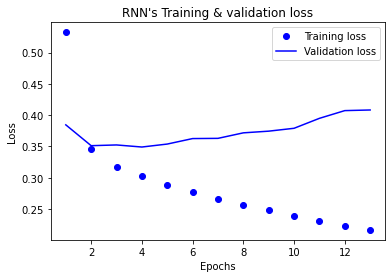

In [19]:
import matplotlib.pyplot as plt

acc_rnn = history_dict_rnn['accuracy']
val_acc_rnn = history_dict_rnn['val_accuracy']
loss_rnn = history_dict_rnn['loss']
val_loss_rnn = history_dict_rnn['val_loss']

epochs_rnn = range(1, len(acc_rnn) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_rnn, loss_rnn, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_rnn, val_loss_rnn, 'b', label='Validation loss')
plt.title('RNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### - Training과 validation의 Accuracy

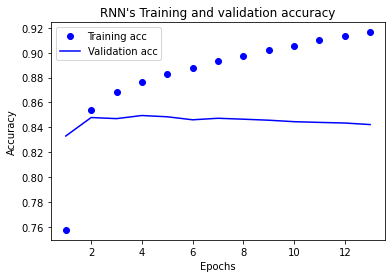

In [20]:
plt.clf()  

plt.plot(epochs_rnn, acc_rnn, 'bo', label='Training acc')
plt.plot(epochs_rnn, val_acc_rnn, 'b', label='Validation acc')
plt.title('RNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (2) 1-D Convolution Neural Network(1-D CNN)

In [21]:
results_oned = model_oned.evaluate(X_test,  y_test, verbose=2)

print(results_oned)

1537/1537 - 1s - loss: 0.7118 - accuracy: 0.8199
[0.7118107676506042, 0.8199239373207092]


In [22]:
history_dict_oned = history_oned.history
print(history_dict_oned.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### - Training과 validation의 Loss

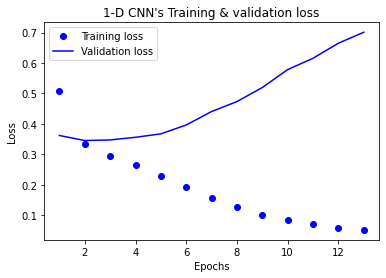

In [23]:
import matplotlib.pyplot as plt

acc_oned = history_dict_oned['accuracy']
val_acc_oned = history_dict_oned['val_accuracy']
loss_oned = history_dict_oned['loss']
val_loss_oned = history_dict_oned['val_loss']

epochs_oned = range(1, len(acc_oned) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_oned, loss_oned, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_oned, val_loss_oned, 'b', label='Validation loss')
plt.title('1-D CNN\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### - Training과 validation의 Accuracy

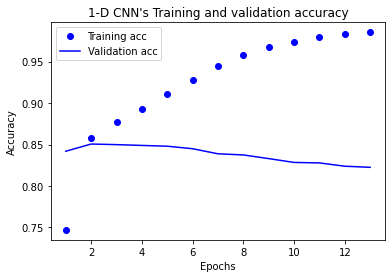

In [24]:
plt.clf()   # 그림을 초기화

plt.plot(epochs_oned, acc_oned, 'bo', label='Training acc')
plt.plot(epochs_oned, val_acc_oned, 'b', label='Validation acc')
plt.title('1-D CNN\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [25]:
results_max = model_max.evaluate(X_test,  y_test, verbose=2)

print(results_max)

1537/1537 - 1s - loss: 0.4544 - accuracy: 0.8308
[0.4543643295764923, 0.8307870626449585]


In [26]:
history_dict_max = history_max.history
print(history_dict_max.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### - Training과 validation의 Loss

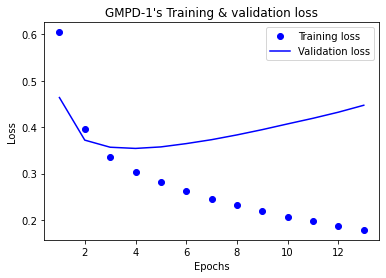

In [27]:
import matplotlib.pyplot as plt

acc_max= history_dict_max['accuracy']
val_acc_max = history_dict_max['val_accuracy']
loss_max = history_dict_max['loss']
val_loss_max = history_dict_max['val_loss']

epochs_max = range(1, len(acc_max) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs_max, loss_max, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs_max, val_loss_max, 'b', label='Validation loss')
plt.title('GMPD-1\'s Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### - Training과 validation의 Accuracy

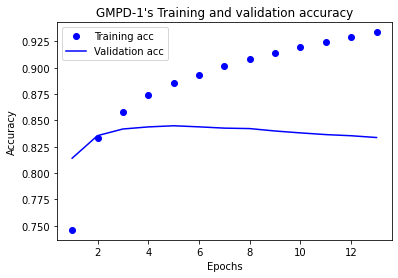

In [28]:
plt.clf()  

plt.plot(epochs_max, acc_max, 'bo', label='Training acc')
plt.plot(epochs_max, val_acc_max, 'b', label='Validation acc')
plt.title('GMPD-1\'s Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Step 7. 학습된 임베딩 레이어 분석

**10. 모델에 사용한 임베딩레이어에 학습된 워드 벡터들이 의미 공간상에 유의미한 형태로 학습되었는지 각 모델별로 확인해봅니다.**

**11. 워드 벡터 파일을 저장할 디렉토리를 먼저 설치하고, 워드 벡터를 다루는데 유용한 ```gensim```패키지를 설치합니다.**

```
$ mkdir -p ~/aiffel/sentiment_classification 
$ pip install gensim
```

## (1) RNN

In [29]:
embedding_layer_rnn = model_rnn.layers[0]
weights_rnn = embedding_layer_rnn.get_weights()[0]
print(weights_rnn.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [30]:
import os

# 학습한 Embedding 파라미터를 새로운 파일에 써서 저장
word2vec_rnn_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_rnn.txt'
f_rnn = open(word2vec_rnn_file_path, 'w')
f_rnn.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀을 작성

# 단어 개수에서 특수문자 4개는 제외하고, 그 만큼 워드 벡터를 파일에 기록 
vectors_rnn = model_rnn.get_weights()[0]
for i in range(4,vocab_size):
    f_rnn.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_rnn[i, :])))))
f_rnn.close()

**12. ```gensim```패키지를 이용해 위에 저장해둔 임베딩 파라미터를 읽어서 word vector로 활용합니다.**

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_rnn = Word2VecKeyedVectors.load_word2vec_format(word2vec_rnn_file_path, binary=False)
vector_rnn = word_vectors_rnn['연기']
vector_rnn

array([-0.00642731, -0.10118901, -0.05817578,  0.01980067, -0.012681  ,
       -0.01039419, -0.00219101,  0.01381662, -0.00521243,  0.00991647,
       -0.05073854,  0.06537293, -0.16604538,  0.05279299, -0.01637626,
       -0.08041219], dtype=float32)

**13. 학습된 워드 벡터들이 의미 공간 상에 유의미하게 학습되었는지 보기 위해 단어를 하나 주고, 해당 단어와 가장 유사한 단어와 유사도를 함께 확인해봅니다.**

In [32]:
word_vectors_rnn.similar_by_word("더빙")

[('코난', 0.8944461345672607),
 ('촌', 0.8943742513656616),
 ('미흡', 0.8893980979919434),
 ('애국', 0.8848956823348999),
 ('\\', 0.8783154487609863),
 ('저절로', 0.876048743724823),
 ('심야', 0.8725833892822266),
 ('청소년', 0.8716872930526733),
 ('-;', 0.8701269030570984),
 ('애매', 0.866844892501831)]

**- RNN의 경우, 유사도는 높지만 유사한 단어를 잘 찾진 못한 것 같습니다. 감성분류 태스크를 짧게 학습하여 워드 벡터가 정교하게 학습되지 않은 것 같습니다.**

**14. 나머지 모델들도 같은 작업을 반복하여 의미 공간에 워드 벡터들이 유의미하게 학습됐는지 평가해봅니다.**

## (2) 1-D Convolution Neural Network(1-D CNN)

In [33]:
embedding_layer_oned = model_oned.layers[0]
weights_oned = embedding_layer_oned.get_weights()[0]
print(weights_oned.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [34]:
import os

# 학습한 Embedding 파라미터를 새로운 파일에 써서 저장
word2vec_oned_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_oned.txt'
f_oned = open(word2vec_oned_file_path, 'w')
f_oned.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀을 작성

# 단어 개수에서 특수문자 4개는 제외하고, 그 만큼 워드 벡터를 파일에 기록 
vectors_oned = model_oned.get_weights()[0]
for i in range(4,vocab_size):
    f_oned.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_oned[i, :])))))
f_oned.close()

In [35]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_oned = Word2VecKeyedVectors.load_word2vec_format(word2vec_oned_file_path, binary=False)
vector_oned = word_vectors_oned['연기']
vector_oned

array([ 0.01948173,  0.09163849,  0.02444379, -0.05861961,  0.00273084,
       -0.01205542, -0.01800368, -0.00393381, -0.09545224,  0.06202898,
       -0.00873462, -0.02659951, -0.02645925,  0.0171994 , -0.07349576,
        0.01159025], dtype=float32)

In [36]:
word_vectors_oned.similar_by_word("더빙")

[('전반', 0.7031528353691101),
 ('사례', 0.6973624229431152),
 ('일으키', 0.6899771094322205),
 ('프랑스', 0.6876668930053711),
 ('떵', 0.6661902666091919),
 ('기반', 0.6497173309326172),
 ('류', 0.6438673734664917),
 ('돌려도', 0.6406442523002625),
 ('성형', 0.6295326948165894),
 ('위원회', 0.6291210055351257)]

**- 출력된 단어들을 보니 역시 그닥 연관있는 단어를 찾아냈다는 생각이 들지 않습니다. 심지어 유사도도 RNN보다 전반적으로 낮습니다.**

## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

In [37]:
embedding_layer_max = model_max.layers[0]
weights_max = embedding_layer_max.get_weights()[0]
print(weights_max.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [38]:
import os

# 학습한 Embedding 파라미터를 새로운 파일에 써서 저장
word2vec_max_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec_max.txt'
f_max = open(word2vec_max_file_path, 'w')
f_max.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇 개의 벡터를 얼마 사이즈로 기재할지 타이틀을 작성

# 단어 개수에서 특수문자 4개는 제외하고, 그 만큼 워드 벡터를 파일에 기록 
vectors_max = model_max.get_weights()[0]
for i in range(4,vocab_size):
    f_max.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors_max[i, :])))))
f_max.close()

In [39]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors_max = Word2VecKeyedVectors.load_word2vec_format(word2vec_max_file_path, binary=False)
vector_max = word_vectors_max['연기']
vector_max

array([-0.07225871, -0.16507478, -0.1238968 , -0.09631079, -0.15903309,
       -0.17126913, -0.13083518, -0.04388511,  0.13419177, -0.05268682,
       -0.03858693, -0.02866168, -0.16525193, -0.113308  , -0.15127529,
       -0.02325885], dtype=float32)

In [40]:
word_vectors_max.similar_by_word("더빙")

[('바보', 0.8962305188179016),
 ('기괴', 0.8789158463478088),
 ('맙소사', 0.8720240592956543),
 ('짬뽕', 0.8674640655517578),
 ('하아', 0.8664179444313049),
 ('식', 0.865066647529602),
 ('잖아', 0.861068844795227),
 ('이치', 0.8559722900390625),
 ('살인', 0.8529903888702393),
 ('버려', 0.8523539304733276)]

**- 1-D CNN보다 유사도는 전반적으로 높지만 사람인 제가 봤을 땐 단어의 유사성이 크게 보이지 않습니다.**

# Step 8. 한국어 word2vec 임베딩을 활용하여 성능개선

**15. 사전 학습된 한국어 word2Vec 모델을 가져와 적용해 봅니다. [한국어 word2vec](https://github.com/Kyubyong/wordvectors)에서 ```Pre-trained models```챕터로 가서 ```Korean```을 찾습니다. 2가지 선택지가 있을 텐데 ```f```을 눌러서 구글 드라이브 안으로 들어갑니다. 500MB이상의 파일을 다운받아줍니다.**      
**- 해당 한국어 word2vec은 벡터사이즈가 200이고, 코퍼스 사이즈가 339M이며, 단어 사이즈가 30185입니다.**

**16. 다운받은 파일이 다운로드에 들어가있을테니 ```sentiment_classification```디렉토리를 옮겨줍니다. 그리고 압축을 풀어줍니다.**

**17. word2vec모델을 가져와 적용해봅니다. 구글의 word2vec모델보다는 단어 수가 적으니 limit을 풀어줍니다.** 

In [41]:
from gensim.models import KeyedVectors

kor_word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.vec'
kor_word2vec = KeyedVectors.load_word2vec_format(kor_word2vec_path, binary=False, limit=None)
kor_vector = kor_word2vec['연기']
kor_vector
print(kor_vector.shape)

(200,)


**18. 워드 벡터들끼리 의미적 유사도가 가까운지 한번 확인해봅니다. 정말 사전학습이 잘됐군요!**

In [42]:
kor_word2vec.similar_by_word("연기")

[('연기자', 0.5190777778625488),
 ('조연', 0.5179136991500854),
 ('배역', 0.5166990756988525),
 ('성우', 0.4867153763771057),
 ('주연', 0.47795748710632324),
 ('연출', 0.4733768105506897),
 ('여배우', 0.4732450544834137),
 ('각본', 0.46500182151794434),
 ('극본', 0.45965006947517395),
 ('주연상', 0.4530304968357086)]

# Step 9. 임베딩 레이어 교체

**19. 더 좋은 임베딩 레이어를 얻으니 임베링 레이어를 좋은 것으로 교체해줍니다.**

In [43]:
vocab_size = 10000    
word_vector_dim = 200  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in kor_word2vec:
        embedding_matrix[i] = kor_word2vec[index_to_word[i]]

**20. 위에서 구현했던 모델 3가지의 레이어를 바꿔서 다시 시도해봅니다.**

## (1) RNN

**- 모델 구성하기**

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 200

model_rnn = keras.Sequential()
model_rnn.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_rnn.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8
model_rnn.add(keras.layers.Dense(8, activation='relu'))
model_rnn.add(keras.layers.Dense(1, activation='sigmoid'))  

model_rnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


**- 모델 훈련하기**

In [54]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 12

history_rnn = model_rnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/12
188/188 [==============================] - 10s 54ms/step - loss: 0.4880 - accuracy: 0.7692 - val_loss: 0.3799 - val_accuracy: 0.8346
Epoch 2/12
188/188 [==============================] - 9s 50ms/step - loss: 0.3464 - accuracy: 0.8550 - val_loss: 0.3515 - val_accuracy: 0.8485
Epoch 3/12
188/188 [==============================] - 9s 51ms/step - loss: 0.3089 - accuracy: 0.8737 - val_loss: 0.3514 - val_accuracy: 0.8498
Epoch 4/12
188/188 [==============================] - 9s 50ms/step - loss: 0.2842 - accuracy: 0.8846 - val_loss: 0.3489 - val_accuracy: 0.8516
Epoch 5/12
188/188 [==============================] - 9s 50ms/step - loss: 0.2643 - accuracy: 0.8940 - val_loss: 0.3608 - val_accuracy: 0.8457
Epoch 6/12
188/188 [==============================] - 9s 50ms/step - loss: 0.2472 - accuracy: 0.9029 - val_loss: 0.3627 - val_accuracy: 0.8524
Epoch 7/12
188/188 [==============================] - 9s 50ms/step - loss: 0.2294 - accuracy: 0.9104 - val_loss: 0.3726 - val_accuracy: 0.850

**- 모델 평가하기**

In [55]:
results_rnn = model_rnn.evaluate(X_test,  y_test, verbose=2)

print(results_rnn)

1537/1537 - 3s - loss: 0.4578 - accuracy: 0.8405
[0.4577912986278534, 0.8405110239982605]


## (2) 1-D Convolution Neural Network(1-D CNN)

**- 모델 구성하기**

In [56]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import Constant

vocab_size = 10000 
word_vector_dim = 200  

model_oned = keras.Sequential()
model_oned.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_oned.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_oned.add(keras.layers.MaxPooling1D(5))
model_oned.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_oned.add(keras.layers.GlobalMaxPooling1D())
model_oned.add(keras.layers.Dense(8, activation='relu'))
model_oned.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_oned.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

**- 모델 훈련하기**

In [57]:
model_oned.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 12

history_oned = model_oned.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/12
188/188 [==============================] - 10s 53ms/step - loss: 0.5396 - accuracy: 0.7058 - val_loss: 0.3906 - val_accuracy: 0.8253
Epoch 2/12
188/188 [==============================] - 11s 57ms/step - loss: 0.3552 - accuracy: 0.8458 - val_loss: 0.3581 - val_accuracy: 0.8443
Epoch 3/12
188/188 [==============================] - 11s 56ms/step - loss: 0.3086 - accuracy: 0.8713 - val_loss: 0.3520 - val_accuracy: 0.8480
Epoch 4/12
188/188 [==============================] - 10s 55ms/step - loss: 0.2737 - accuracy: 0.8885 - val_loss: 0.3540 - val_accuracy: 0.8516
Epoch 5/12
188/188 [==============================] - 10s 55ms/step - loss: 0.2380 - accuracy: 0.9073 - val_loss: 0.3707 - val_accuracy: 0.8501
Epoch 6/12
188/188 [==============================] - 10s 55ms/step - loss: 0.2010 - accuracy: 0.9255 - val_loss: 0.4150 - val_accuracy: 0.8364
Epoch 7/12
188/188 [==============================] - 10s 55ms/step - loss: 0.1615 - accuracy: 0.9432 - val_loss: 0.4235 - val_accuracy:

**- 모델 평가하기**

In [58]:
results_oned = model_oned.evaluate(X_test,  y_test, verbose=2)

print(results_oned)

1537/1537 - 1s - loss: 0.7082 - accuracy: 0.8228
[0.7081843018531799, 0.8227515816688538]


## (3) GlobalMaxPooling1D() 레이어 하나만 사용하는 방법

**- 모델 구성하기**

In [59]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.initializers import Constant
 
vocab_size = 10000  
word_vector_dim = 200  

model_max = keras.Sequential()
model_max.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model_max.add(keras.layers.GlobalMaxPooling1D())
model_max.add(keras.layers.Dense(8, activation='relu'))
model_max.add(keras.layers.Dense(1, activation='sigmoid'))

model_max.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 200)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


**- 모델 학습하기**

In [60]:
model_max.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs = 12

history_max = model_max.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/12
188/188 [==============================] - 5s 25ms/step - loss: 0.6474 - accuracy: 0.6339 - val_loss: 0.5806 - val_accuracy: 0.7262
Epoch 2/12
188/188 [==============================] - 5s 25ms/step - loss: 0.5142 - accuracy: 0.7666 - val_loss: 0.4728 - val_accuracy: 0.7784
Epoch 3/12
188/188 [==============================] - 5s 25ms/step - loss: 0.4169 - accuracy: 0.8155 - val_loss: 0.4204 - val_accuracy: 0.8047
Epoch 4/12
188/188 [==============================] - 5s 26ms/step - loss: 0.3630 - accuracy: 0.8436 - val_loss: 0.4008 - val_accuracy: 0.8168
Epoch 5/12
188/188 [==============================] - 5s 25ms/step - loss: 0.3297 - accuracy: 0.8601 - val_loss: 0.3969 - val_accuracy: 0.8208
Epoch 6/12
188/188 [==============================] - 5s 25ms/step - loss: 0.3042 - accuracy: 0.8739 - val_loss: 0.3910 - val_accuracy: 0.8258
Epoch 7/12
188/188 [==============================] - 5s 25ms/step - loss: 0.2822 - accuracy: 0.8847 - val_loss: 0.3929 - val_accuracy: 0.8277

**- 모델 평가하기**

In [61]:
results_max = model_max.evaluate(X_test,  y_test, verbose=2)

print(results_max)

1537/1537 - 1s - loss: 0.4404 - accuracy: 0.8233
[0.44044798612594604, 0.823300838470459]
